# Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ for DESIJ1624+0129

**Authors**: Ahmad Al - Imtiaz, Sulyman Hossain, S M Rafee Adnan, Anowar Shajib

## Import Libraries

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

## Load Data

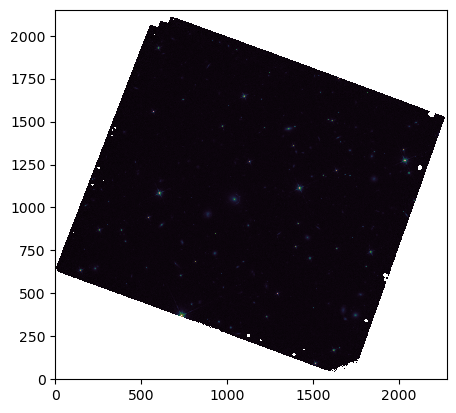

In [16]:
data, header = fits.getdata("D:\Study\Astronomy_Astrophysics\BDLensing\Lens systems I have modeled\DESIJ0618+5018_final\DESIJ0618+5018_F140W_drz_sci.fits", header=True)
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

C:\Users\ahmad\AppData\Local\Temp\ipykernel_2184\3998831433.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


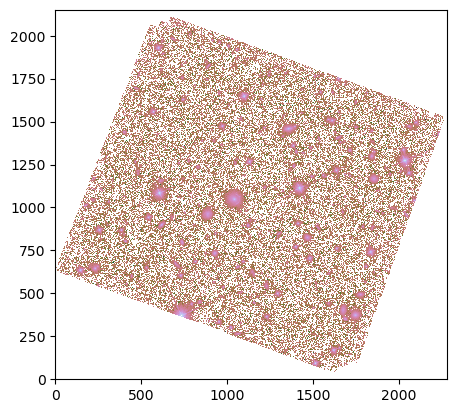

In [17]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture Photometry and Plotting

C:\Users\ahmad\AppData\Local\Temp\ipykernel_2184\2329128051.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


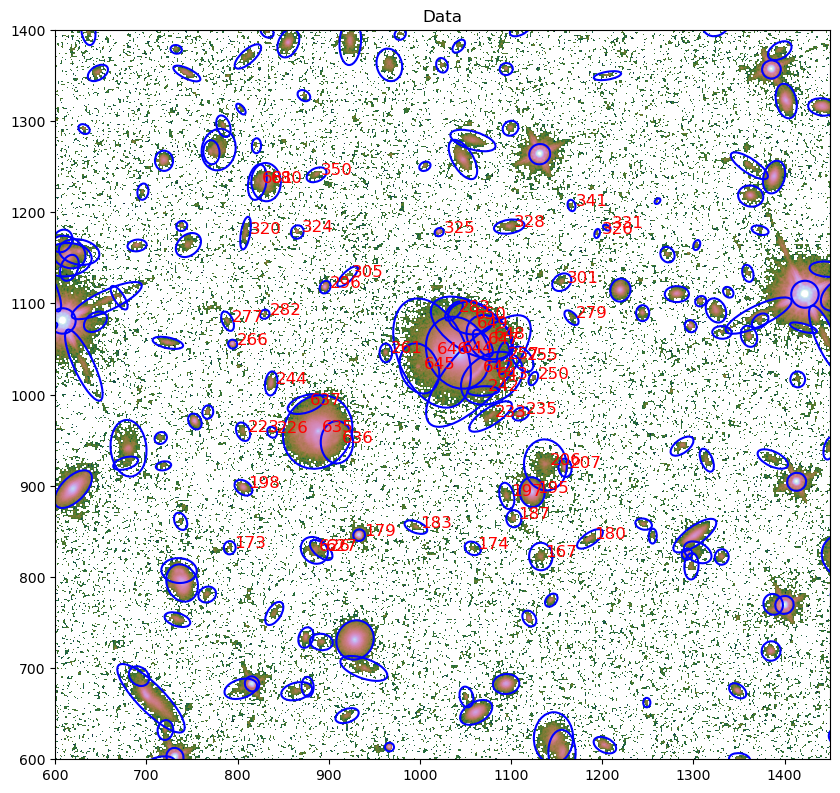

In [18]:
# Background subtraction
bkg_subtracted_data = data - bkg.background

# Source detection and segmentation
threshold = 3 * bkg.background_rms
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=8,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

# Source catalog creation
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)

# Plotting
norm = simple_norm(data, "sqrt")
fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

# Plot Kron apertures and label nearby sources
cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[645]) < 220
        and np.abs(cat.ycentroid[i] - cat.ycentroid[645]) < 220
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

# Set axis limits
set_x_lim1, set_x_lim2 = 600, 1450
set_y_lim1, set_y_lim2 = 600, 1400

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# Hide text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

# Show the plot
plt.show()

## Identify the central deflector's ID

C:\Users\ahmad\AppData\Local\Temp\ipykernel_2184\3687620710.py:10: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


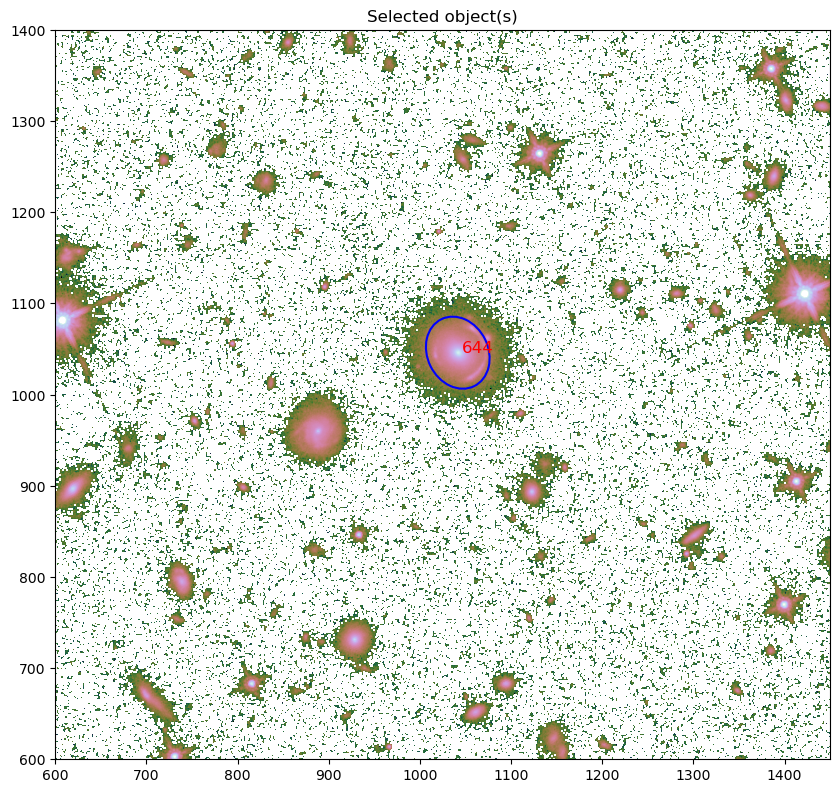

In [19]:
# Defining a function for labeling only selected objects
def label_selected_objects(selected_ids):
    # Background subtraction
    data - bkg.background

    # Plotting
    simple_norm(data, "sqrt")
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
    ax1.imshow(
        np.log10(data - bkg.background),
        origin="lower",
        cmap="cubehelix",
        vmin=-4,
        vmax=2,
    )
    ax1.set_title("Selected object(s)")

    # Plot Kron apertures and label selected objects
    for obj_id in selected_ids:
        labels = [obj_id + 1]
        cat_subset = cat.get_labels(labels)
        cat_subset.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

        ax1.text(
            cat.xcentroid[obj_id] + 5,
            cat.ycentroid[obj_id],
            f"{obj_id}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )

    # Set axis limits
    ax1.set_xlim(set_x_lim1, set_x_lim2)
    ax1.set_ylim(set_y_lim1, set_y_lim2)

    # Hide text outside of the axes
    ax1.set_clip_on(True)
    ax1.set_clip_box(ax1.bbox)

    # Show the plot
    plt.show()


# Guessing the lens galaxy
id_central = [644]

# Calling the function label id_central
label_selected_objects(id_central)

In [20]:
# optional format
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating A List of Neighboring Galaxies

In [21]:
# All close galaxies
x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 30 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 30 arcsecond radius: 118


In [22]:
# Close galaxies excluding sources lower than 1% of the central deflector
x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 30 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 30 arcsecond radius: 31


## Pixels to Arcsec unit

In [23]:
def distance_arcsec(pixel_distance):
    """Convert distance from unit of pixels into arcsec unit.

    :param pixel_distance: distance in unit of pixels
    :return: distance in arcsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

## Identify the unwanted objects

C:\Users\ahmad\AppData\Local\Temp\ipykernel_2184\3687620710.py:10: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


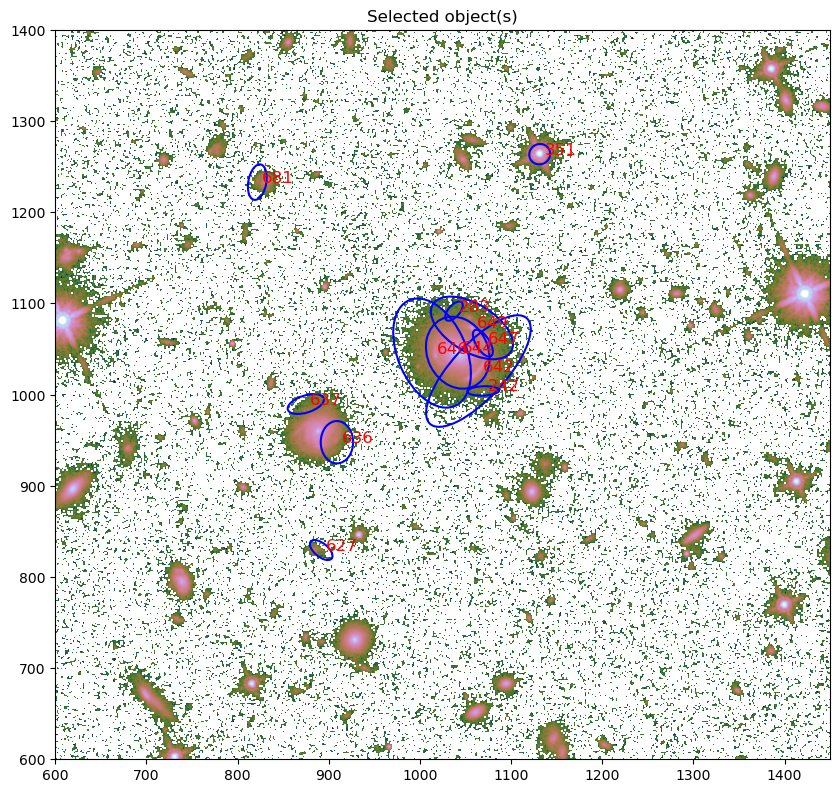

In [24]:
unwanted_object_ids = [242, 283, 351, 627, 636, 637, 642, 644, 646, 647, 649, 681]
label_selected_objects(unwanted_object_ids)

## Removing the unwanted objects from the neighboring galaxy list

In [25]:
# All close galaxies
remove_list = [ 242, # unnecessary artifact
               283, # unnecessary artifacts
               351, #star
               627, # artifact of 626
               636, # artifact of 635
               637, # artifact of 635
               642, # part of the arc
               644, # central deflector
               646, # part of the arc
               647, # part of the arc
               649, # part of the arc
               681 # artifact of 680
]

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

         Distance(pixels)      Distance(arcsec)        Flux  Axis Ratio
648  [37.583319524431175]  [3.0066655619544638]   97.982426    0.786929
650  [40.507588704396525]  [3.2406070963516895]   48.183012    0.716367
645    [45.3812358933678]  [3.6304988714693875]   47.369059    0.728941
643   [46.67454729605821]   [3.733963783684619]   76.019903    0.711436
257   [50.23294120294128]   [4.018635296235262]   13.238335    0.391568
255   [71.44883169561534]    [5.71590653564917]    8.817214    0.614739
233   [78.68631410501771]   [6.294905128401354]   15.086672    0.346818
261    [78.9187465870656]   [6.313499726965184]    6.256227    0.663768
250   [87.55773125453875]    [7.00461850036303]    2.619682    0.566603
235   [96.33856706360662]   [7.707085365088452]   16.231824    0.698945
279  [130.51832712819612]  [10.441466170255584]    2.566081    0.540374
325  [133.78085599933837]  [10.702468479946962]   10.439101    0.848951
301  [137.80268769669206]  [11.024215015735255]    5.492238    0

In [26]:
# Excluding galaxies lower than 1% of the central deflector
remove_list_1 = [ 351, #star
               636, # artifact of 635
               642, # part of the arc
               644, # central deflector
               646, # part of the arc
               647, # part of the arc
               649, # part of the arc
]
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})
df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratioe"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

         Distance(pixels)      Distance(arcsec)        Flux  Axis Ratioe
648  [37.583319524431175]  [3.0066655619544638]   97.982426     0.786929
650  [40.507588704396525]  [3.2406070963516895]   48.183012     0.716367
645    [45.3812358933678]  [3.6304988714693875]   47.369059     0.728941
643   [46.67454729605821]   [3.733963783684619]   76.019903     0.711436
206  [156.18979625416557]   [12.49518370033312]   38.758291     0.834649
296   [162.2985690570913]  [12.983885524567173]   22.838727     0.788047
195  [173.38209238418693]  [13.870567390734815]  203.608751     0.836388
635  [176.48651285579726]  [14.118921028463639]  877.854214     0.883413
290   [191.1022745857255]  [15.288181966857886]   67.562377     0.877192
353  [211.96597890468868]  [16.957278312374925]   44.546321     0.467997
179  [227.49885659693732]  [18.199908527754804]  135.164297     0.962763
363  [233.27984209701864]  [18.662387367761305]   23.247039     0.380471
291  [248.75632589731575]   [19.90050607178506]   2

## Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ and the corresponding radii

In [27]:
# One faint object (along 9 o'clock) near the lens galaxy was undetected due to
# threshold conditions. To include this object in the calculation, we only take
# the distance of the 9th and 19th closest galaxies to calculate R_10 and R_20,
# which includes dim sources.
R_10_all = df_all_20.iloc[9 , df_all_20.columns.get_loc("Distance(arcsec)")]
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)


# But we are not considering the previously described faint object in the list that
# excludes dim objects
R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(arcsec)")]
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)


FOR All SOURCES
R 10: [7.70708537]
R 20: [13.87056739]
Sigma 10: [0.05358828]
Sigma 20: [0.03308961]

EXCLUDING DIM SOURCES
R 10: [16.95727831]
R 20: [26.77332367]
Sigma 10: [0.01106975]
Sigma 20: [0.00888128]


## Visualization

C:\Users\ahmad\AppData\Local\Temp\ipykernel_2184\3297961459.py:19: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
C:\Users\ahmad\AppData\Local\Temp\ipykernel_2184\3297961459.py:22: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
C:\Users\ahmad\AppData\Local\Temp\ipykernel_2184\3297961459.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
C:\Users\ahmad\AppData\Local\Temp\ipykernel_2184\3297961459.py:28: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


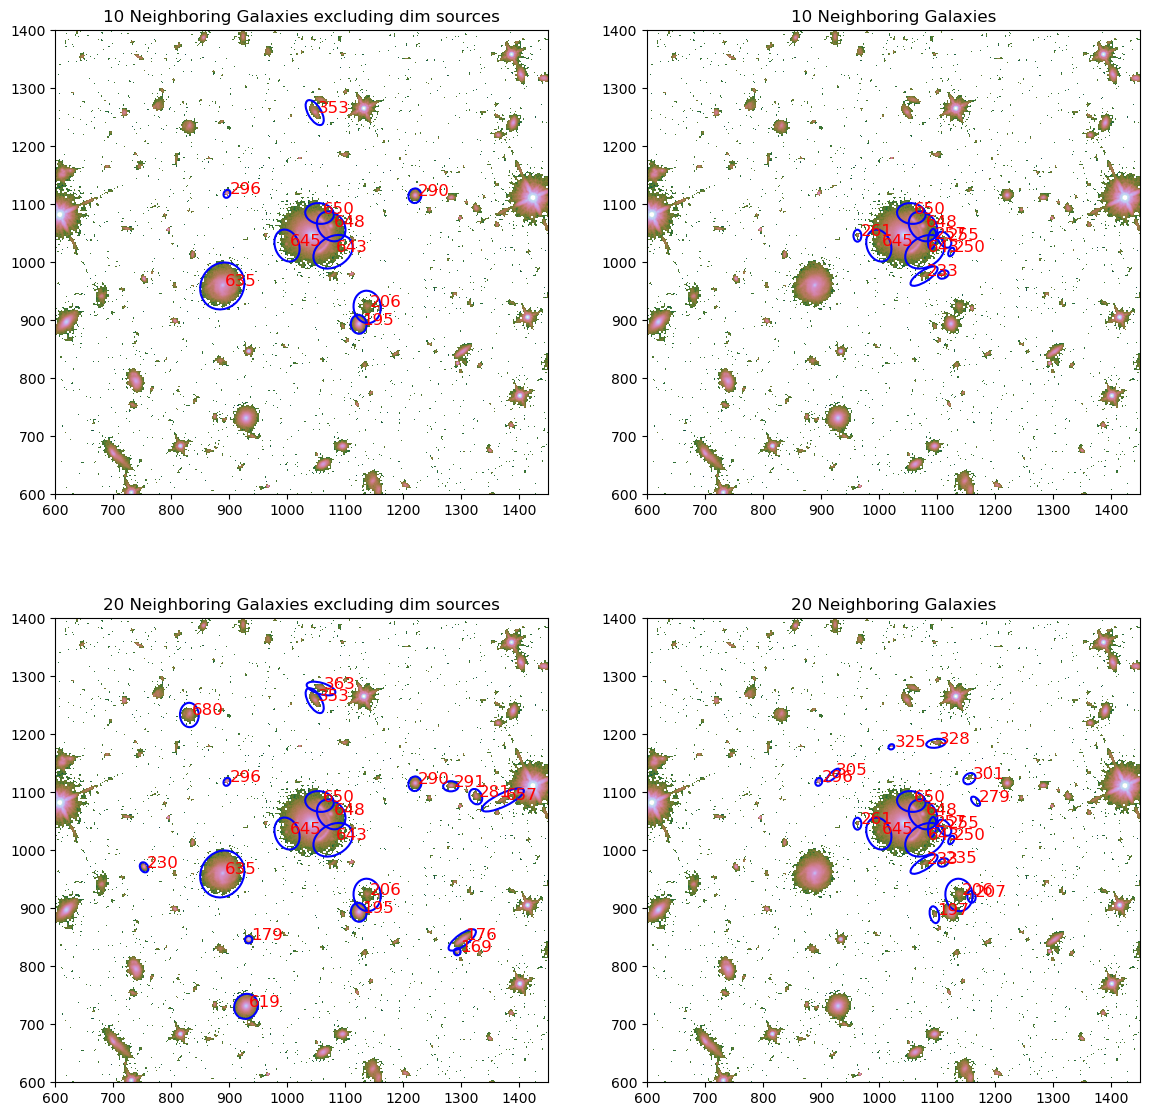

In [28]:
close_ids_all = list(df_all_20.index.values)
close_ids_all.pop(19)
close_ids_all_10 = close_ids_all[:10]
close_ids_all_10.pop(9)

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighboring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighboring Galaxies")
axs[1, 0].set_title("20 Neighboring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighboring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

## Store the results to the YAML file

In [31]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ0618+5018_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20_flux_selected": Sigma_20_1,
    "Sigma_10": Sigma_10_all,
    "Sigma_20": Sigma_20_all,
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

C:\Users\ahmad\AppData\Local\Temp\ipykernel_2184\3828288091.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  key: [float(item) for item in value] if isinstance(value, list) else float(value)


In [32]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 0.8194236223102188, 'Sigma_10': 0.05358827638786983, 'Sigma_10_flux_selected': 0.011069750464684381, 'Sigma_20': 0.033089611599741046, 'Sigma_20_flux_selected': 0.008881279675099127, 'center_x_light': [-0.17150506588084782, 0.0008462895042265495, 0.0006756127818671742], 'center_x_mass': [-0.43596095614981645, 0.0011875616155935798, 0.001476021041531328], 'center_y_light': [-0.020121544660983974, 0.00051480747842109, 0.0005444647451639112], 'center_y_mass': [0.08456579623020608, 0.0019702751257763967, 0.0020094306669806716], 'gamma': 2.0, 'gamma_shear': [0.07405637309949187, 0.0008756157911989776, 0.001068798041857083], 'phi_light': [0.5472760709507563, 0.007315299079435622, 0.005707002575564113], 'phi_mass': [1.4541932610836583, 0.005539180112837938, 0.005225184230940982], 'phi_shear': [1.3798700347423245, 0.008117189722143703, 0.0074249132633901205], 'q_light': [0.7916033467132746, 0.0019408592709287964, 0.0021309794862119924], 'q_mass':